<a href="https://colab.research.google.com/github/bearbearyu1223/Graph-Neural-Network-Study-Notes/blob/main/heterogeneous_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heterogeneous Graph 

An example of a **homogeneous graph** is an online social network with nodes representing people and edges representing friendship, where **the type of nodes and edges are always the same**. On the other hand, a graph with two or more types of node and/or two or more types of edge is called **heterogeneous**.

## Setup

In [ ]:
import torch 
import os
print("PyTorch Version : {}".format(torch.__version__))

!pip uninstall torch-scatter
!pip uninstall torch-sparse
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

PyTorch Version : 2.0.0+cu118
Found existing installation: torch-scatter 2.1.1+pt113cu116
Uninstalling torch-scatter-2.1.1+pt113cu116:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/torch_scatter-2.1.1+pt113cu116.dist-info/*
    /usr/local/lib/python3.9/dist-packages/torch_scatter/*
Proceed (Y/n)? y
  Successfully uninstalled torch-scatter-2.1.1+pt113cu116
Found existing installation: torch-sparse 0.6.17+pt113cu116
Uninstalling torch-sparse-0.6.17+pt113cu116:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/torch_sparse-0.6.17+pt113cu116.dist-info/*
    /usr/local/lib/python3.9/dist-packages/torch_sparse/*
Proceed (Y/n)? y
  Successfully uninstalled torch-sparse-0.6.17+pt113cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_scatter-2.1.1%2Bpt113cu116-cp39-cp39-linux_x86_

In [ ]:
!nvcc --version
!python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
11.8


In [ ]:
import torch_geometric
print("PyG version :{}".format(torch_geometric.__version__))

/usr/local/lib/python3.9/dist-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.9/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.9/dist-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.9/dist-packages/torch_sparse/_diag_cuda.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


PyG version :2.3.0


## DeepSNAP Heterogenous Graph
[DeepSNAP](https://github.com/snap-stanford/deepsnap) extends its traditional graph representation to include heterogenous graphs by including the following graph property features: 


* node_feature: The feature of each node 
* edge_feature: The feature of each edge
* node_label: The label of each node
* node_type: The type of each node
* edge_type: The type of each eadge



In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt 
import copy
from pylab import show

###  Karate Club Graph
Each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer").

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]


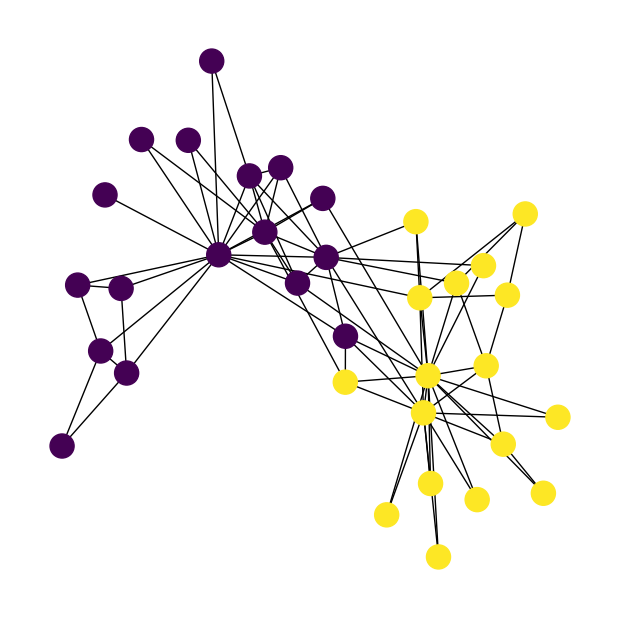

In [ ]:
G = nx.karate_club_graph()
print(G.nodes(data=True)) # Task a look at the data in the graph
community_map = {}
for node in G.nodes(data=True): 
  if node[1]["club"] == "Mr. Hi":
    community_map[node[0]] = 0  
  else: 
    community_map[node[0]] = 1
node_color = []
color_map = {0:0, 1:1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos, cmap=plt.get_cmap("viridis"), node_color = node_color)
show()

### Assign Node Type and Node Features 

For `node_type`, assign nodes in the "Mr.Hi" club to a node type `n0` and nodes in "Officer" club a node type `n1`. 

For `node_label`, assigne nodes in the "Mr.Hi" club to a `0` and nodes in the "Office" club to a `1`. 

Assign every node the tensor feature vector `[1, 1, 1, 1, 1]`. 

In [ ]:
def assign_node_types(G, community_map): 
  values = {}
  for node in G.nodes(data=True): 
    if community_map[node[0]] == 0:
      values[node[0]] = "n0"
    else: 
      values[node[0]] = "n1"
  nx.classes.function.set_node_attributes(G, values, name="node_type")

def assign_node_labels(G, community_map): 
  nx.classes.function.set_node_attributes(G, community_map, name="node_label")

def assign_node_features(G): 
  nx.classes.set_node_attributes(G, [1.0, 1.0, 1.0, 1.0, 1.0], name="node_feature")

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)

node_id = 0
print("Node {} has properties {}".format(node_id, G.nodes(data=True)[node_id]))

Node 0 has properties {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}


### Assign Edge Types


* Edges with club "Mr.Hi": `e0`
* Edges with club "Officer": `e1`
* Edges between the two clubs: `e2`

In [ ]:
def assign_edge_types(G, community_map): 
  values = {}
  for edge in G.edges(data=True):
    if community_map[edge[0]] == 0 and community_map[edge[1]] == 0:
      values[(edge[0], edge[1])] = "e0"
    elif community_map[edge[0]] == 1 and community_map[edge[1]] == 1:
      values[(edge[0], edge[1])] = "e1"
    else:
      values[(edge[0], edge[1])] = "e2"
  nx.classes.function.set_edge_attributes(G, values, name="edge_type")

assign_edge_types(G, community_map)
edge_idx = 15
n1 = 0
n2 = 31
edge = list(G.edges(data=True))[edge_idx]
print(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print(f"Node {n1} has properties:", G.nodes(data=True)[n1])
print(f"Node {n2} has properties:", G.nodes(data=True)[n2])

Edge (0, 31) has properties: {'weight': 2, 'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]}


### Visualize the Heterogenos Graph 

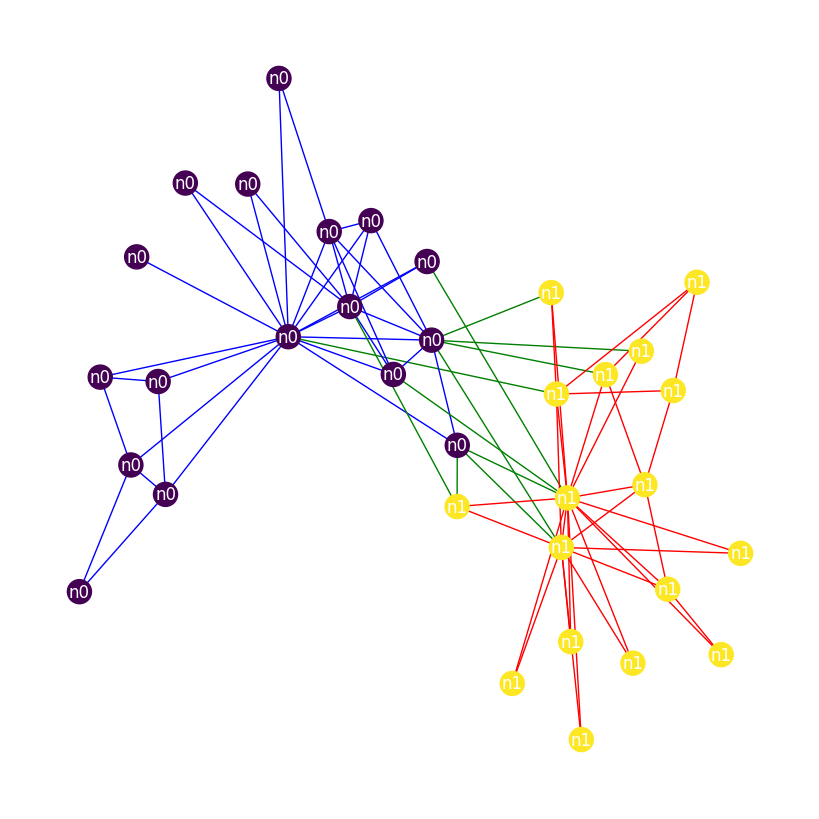

In [ ]:
edge_color = {}
for edge in G.edges():
  n1, n2 = edge
  edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
  if community_map[n1] == community_map[n2] and community_map[n1] == 0:
    edge_color[edge] = 'blue'
  elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
    edge_color[edge] = 'red'
  else:
    edge_color[edge] = 'green'
G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('viridis'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

### Transform the NetworkX Graph to DeepSNAP Graph Representation